In [0]:
import argparse
import yaml
import time
import datetime
import cv2
import numpy as np
import pandas as pd
import random

from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage, misc

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch
from torch.autograd import Variable
import torch.optim as optim

from google.colab import drive
import os
import warnings
from collections import defaultdict

from scipy import stats

In [0]:
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/Mosquito-Tec')

Mounted at /content/drive


In [0]:
### Dataset functions
def paddedzoom(img, zoomfactor = 0.8):
    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx = zoomfactor, fy = zoomfactor)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    if zoomfactor < 1:    
        out[int((h - zh) / 2):int(-(h - zh) / 2), 
            int((w - zw) / 2):int(-(w - zw) / 2), :] = zoomed
    else:
        out = zoomed[int((zh - h) / 2):int(-(zh - h) / 2), 
                     int((zw - w) / 2):int(-(zw - w) / 2), :]

    return out

class SentinelDataset(Dataset):

    def __init__(self, csv_file, root_dir, sentinel_columns, categorical_columns, numerical_columns, output_columns, training = True, transform = None):
        self.sentinel_frame = pd.read_csv(csv_file)

        self.sentinel_frame = self.sentinel_frame[sentinel_columns] 

        self.sentinel_frame["TRAPSET"]= pd.to_datetime(self.sentinel_frame["TRAPSET"]).dt.week
        self.sentinel_frame["TRAPCOLLECT"]= pd.to_datetime(self.sentinel_frame["TRAPCOLLECT"]).dt.week


        self.outputs = output_columns
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns


        for category in self.categorical_columns:
            self.sentinel_frame[category] = self.sentinel_frame[category].astype('category')

        self.num_means = {}
        self.num_maxs = {}
        self.num_mins = {}


        for col in numerical_columns:
            cur_col = self.sentinel_frame[col]
            self.num_means[col] = cur_col.mean()
            self.num_maxs[col] = cur_col.max()
            self.num_mins[col] = cur_col.min()

            self.sentinel_frame[col] = (cur_col - self.num_means[col]) / (self.num_maxs[col] - self.num_mins[col])
        
        #print(stats.zscore(self.sentinel_frame, 0))
        #print(self.sentinel_frame)

        #print(self.sentinel_frame.dtypes)
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.mean = np.array([[[0.0151]],[[0.0166]],[[0.0188]],[[0.0181]],[[0.0226]],[[0.0342]],[[0.0385]],[[0.0396]],[[0.0413]],[[0.0310]],[[0.0221]]])
        self.std =  np.array([[[0.0181]],[[0.0201]],[[0.0190]],[[0.0193]],[[0.0191]],[[0.0187]],[[0.0195]],[[0.0207]],[[0.0322]],[[0.0162]],[[0.0145]]])

    def getEmbeddingSize(self):
        categorical_column_sizes = [len(self.sentinel_frame[column].cat.categories) for column in self.categorical_columns]
        embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_column_sizes]

        return embedding_sizes

    def __len__(self):
        return len(self.sentinel_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = str('data' + str(self.sentinel_frame.iloc[idx, 0]) + '.npy')

        img_name = os.path.join(self.root_dir, filename)
        image = np.load(img_name).astype(np.float32) / 65536

        #normalization
        #image = (image - self.mean)/self.std 
        image /= image.max()

        if self.training:
            #random flip
            if np.random.rand() > 0.5:
                image = np.flip(image, axis = 2).copy()

            #random rotate
            image = ndimage.rotate(image, random.randint(-20, 20), axes = [1, 2],
                                   reshape = False)

            # random zoom
            or_image = image.copy()
            image =  np.swapaxes(image,0,2)
            image = paddedzoom(image, 1.0 + (np.random.rand()/2) )
            image =  np.swapaxes(image,0,2)
            if image.shape != or_image.shape:
                image = or_image

        if self.transform:
            image = self.transform(image)

        target = self.sentinel_frame.iloc[idx, -1]
        image = torch.from_numpy(image)

        current_row = self.sentinel_frame.iloc[[idx]]
        ats = []
        for category in self.categorical_columns:
            #ats.append(stats.zscore(current_row[category].cat.codes.values))
            ats.append(current_row[category].cat.codes.values)

        categorical_data = np.stack(ats, 1)
        #print(categorical_data)
        numerical_data = np.stack([current_row[col].values for col in self.numerical_columns], 1)
        #print(numerical_data)

        numerical_data = torch.from_numpy(numerical_data)

        return image, categorical_data, numerical_data, target

In [0]:
def crop(x, th, tw):
        _, _, w, h = x.size()
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return x[:, :, x1:x1 + tw, y1:y1 + th]

In [0]:
# Columns

sentinel_columns = ['YEAR', "OBJECTID", "TRAPTYPE", "ATTRACTANTSUSED", "LATITUDE","LONGITUDE", 
                    "TRAPSET", "SETTIMEOFDAY","TRAPCOLLECT", "COLLECTTIMEOFDAY", "GENUS",
                    "SPECIES", "icon", "sunriseTime","sunsetTime", "moonPhase", 
                    "precipIntensity","precipIntensityMax", "precipProbability", 
                    "temperatureHigh", "temperatureHighTime", "temperatureLow", 
                    "temperatureLowTime","apparentTemperatureHigh", "apparentTemperatureHighTime", 
                    "apparentTemperatureLow","apparentTemperatureLowTime", "dewPoint", 
                    "humidity", "pressure", "windSpeed", "windGust","windGustTime", 
                    "windBearing", "cloudCover","uvIndex", "uvIndexTime", "visibility", 
                    "temperatureMin", "temperatureMinTime", "temperatureMax", "temperatureMaxTime", 
                    "apparentTemperatureMin", "apparentTemperatureMinTime","apparentTemperatureMax", 
                    "apparentTemperatureMaxTime", "TOTAL"]

output_columns = ['TOTAL']

total_categorical_columns = ['TRAPTYPE', 'ATTRACTANTSUSED', 'SETTIMEOFDAY', 
                             'COLLECTTIMEOFDAY', 'GENUS', 'SPECIES', 'YEAR']

categorical_columns = ['ATTRACTANTSUSED', 'TRAPTYPE', 'YEAR']

total_numerical_columns = ['LATITUDE', 'LONGITUDE', 'TRAPSET', 'TRAPCOLLECT', 'sunriseTime', 'sunsetTime', 'moonPhase', 
                        'precipIntensity', 'precipIntensityMax', 'precipProbability', 
                        'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 
                        'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
                        'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 
                        'humidity', 'pressure', 'windSpeed', 'windGust', 'windGustTime', 
                        'windBearing', 'cloudCover', 'uvIndex', 'uvIndexTime','visibility', 
                        'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 
                        'apparentTemperatureMin','apparentTemperatureMinTime', 'apparentTemperatureMax', 
                        'apparentTemperatureMaxTime']

numerical_columns = ['LONGITUDE', 'temperatureHigh', 'LATITUDE', 'humidity',
                     'precipIntensity']

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

train_data = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_train4.csv',
                             root_dir = '/content/drive/My Drive/Colab/mosquito/Sentinel/data_mosquito_final/', 
                             sentinel_columns = sentinel_columns, categorical_columns = categorical_columns, 
                             numerical_columns = numerical_columns, output_columns = output_columns,
                             training = True)

test_data = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_test4.csv',
                            root_dir = '/content/drive/My Drive/Colab/mosquito/Sentinel/data_mosquito_final/', 
                            sentinel_columns = sentinel_columns, categorical_columns = categorical_columns, 
                            numerical_columns = numerical_columns, output_columns = output_columns, training = False)

# Get embedding sizes
embedding_sizes = train_data.getEmbeddingSize()

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
    sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
    sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, 
    num_workers = num_workers)

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


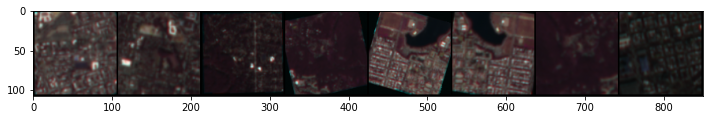

In [0]:
dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, _, _, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
images = images[0:8, 2:5, :, :]
blue = torch.from_numpy(cv2.normalize(images[:, 0, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
green = torch.from_numpy(cv2.normalize(images[:, 1, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
red = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)

images[:, 0, :, :] = red
images[:, 1, :, :] = green
images[:, 2, :, :] = blue

imshow(torchvision.utils.make_grid(images))


In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [0]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Conv2d(c, 32, 4, 2, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, 2, padding = 1),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(64 * z_dim**2, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, n_latent)
        ])
        
    def forward(self, x):
        i = 1
        for layer in self.model:
            x = layer(x)
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Linear(n_latent, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * z_dim**2),
            nn.ReLU(),
            Reshape((64, z_dim, z_dim,)),
            nn.ConvTranspose2d(64, 32, 4, 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, c, 4, 2, padding = 1),
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [0]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [0]:
class MMD_VAE(torch.nn.Module):
    def __init__(self, in_shape, n_latent):
        super(MMD_VAE, self).__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        self.c, self.h, self.w = in_shape
        self.z_dim = self.h // 2**2
        self.encoder = Encoder(self.c, self.z_dim, self.n_latent)
        self.decoder = Decoder(self.c, self.z_dim, self.n_latent)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        x_reconstructed = crop(x_reconstructed, self.h, self.h)
        return z, x_reconstructed

In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes = [1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes = [1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

def train(model, n_epochs, train_loader, valid_loader, optimizer, device, logs_interval, n_latent):
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()

        for batch_idx, (inputs, _, _, _) in enumerate(train_loader):
            inputs = inputs.to(device)
            true_samples = Variable(
                torch.randn(200, n_latent),
                requires_grad = False
            ).to(device)

            z, output = model(inputs)
            mmd = compute_mmd(true_samples, z)
            nll = (output - inputs).pow(2).mean()
            loss = nll + mmd

            optimizer.zero_grad()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()


            if batch_idx % logs_interval == 0:
                print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                        nll.item(), mmd.item()))
                
        model.eval()

        for batch_idx, (inputs, _, _, _) in enumerate(valid_loader):
            inputs = inputs.to(device)
            true_samples = Variable(
                torch.randn(200, n_latent),
                requires_grad = False
            ).to(device)

            z, output = model(inputs)
            mmd = compute_mmd(true_samples, z)
            nll = (output - inputs).pow(2).mean()
            loss = nll + mmd
                
            valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'best_vae.pt')
            valid_loss_min = valid_loss

In [0]:
# Model
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

n_latent = 50

model = MMD_VAE((12, 104, 104), n_latent = n_latent).to(device).double()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters(), lr = 1e-4)

In [0]:
n_epochs = 70

train(model, n_epochs, train_loader, valid_loader, optimizer, device, 20, n_latent)

Negative log likelihood is 0.09674, mmd loss is 0.00077
Negative log likelihood is 0.01826, mmd loss is 0.00109
Negative log likelihood is 0.01738, mmd loss is 0.00059
Negative log likelihood is 0.01633, mmd loss is 0.00061
Negative log likelihood is 0.01308, mmd loss is 0.00060
Epoch: 1 	Training Loss: 0.001661 	Validation Loss: 0.000870
Validation loss decreased (inf --> 0.000870).  Saving model ...
Negative log likelihood is 0.01795, mmd loss is 0.00073
Negative log likelihood is 0.01176, mmd loss is 0.00066
Negative log likelihood is 0.01515, mmd loss is 0.00067
Negative log likelihood is 0.01482, mmd loss is 0.00079
Negative log likelihood is 0.00974, mmd loss is 0.00067
Epoch: 2 	Training Loss: 0.000809 	Validation Loss: 0.000752
Validation loss decreased (0.000870 --> 0.000752).  Saving model ...
Negative log likelihood is 0.01205, mmd loss is 0.00061
Negative log likelihood is 0.01100, mmd loss is 0.00066
Negative log likelihood is 0.00815, mmd loss is 0.00062
Negative log like

In [0]:
model.load_state_dict(torch.load('best_vae.pt'))

<All keys matched successfully>

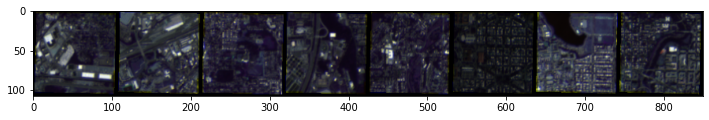

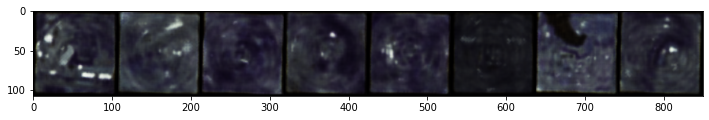

In [0]:
dataiter = iter(test_loader)
# the "_" is a placeholder for no labels
images, _, _, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
images[:, 2, :, :] = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 3, :, :] = torch.from_numpy(cv2.normalize(images[:, 3, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 4, :, :] = torch.from_numpy(cv2.normalize(images[:, 4, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
imshow(torchvision.utils.make_grid(images[0:8, 2:5, :, :]))

_, out = model(images.to(device).double())
fig = plt.figure(figsize=(12, 8))
images2 = out.to('cpu').detach()
imshow(torchvision.utils.make_grid(images2[0:8, 2:5, :, :]))

In [0]:
class LinearModel(nn.Module):
    def __init__(self, n_latent, embedding_sizes, num_numerical_cols):
        super(LinearModel, self).__init__()

        embed_size = 0
        for embed in embedding_sizes:
            embed_size += embed[1]

        self.dense_embed = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(embed_size + num_numerical_cols,30),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(30, 30),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(30, 10), 
            nn.Sigmoid()
        )

        self.dense_latent = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(n_latent, 50),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(50, 30),
            nn.Sigmoid()
        )

        self.dense = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(30 + 10, 30),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(30, 30),
            nn.Sigmoid(),
            nn.Linear(30, 1),
            nn.ReLU()
        )

        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        self.batch_norm_linear = nn.BatchNorm1d(num_numerical_cols)
        self.batch_norm_vae = nn.BatchNorm1d(n_latent)

    def forward(self, x, x_categorical, x_numerical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embed = e(x_categorical[:, i])
            embeddings.append(embed)


        y = torch.cat(embeddings, 1)
        #x_numerical = self.batch_norm_linear(x_numerical)
        y = torch.cat([y, x_numerical], 1)
        #x = self.batch_norm_vae(x)

        x = self.dense_latent(x)
        y = self.dense_embed(y)

        mixtensor = torch.cat((x, y), 1)
        
        out = self.dense(mixtensor)

        return out

In [0]:
def train_dense(model_vae, model_linear, n_epochs, train_loader, valid_loader, 
                optimizer, criterion, device, logs_interval, n_latent):
    valid_loss_min = np.Inf

    model_vae.eval()

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model_linear.train()

        for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(train_loader):
            inputs = inputs.to(device)
            categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
            numerical_data = numerical_data.squeeze().type(torch.double).to(device)
            target = target.squeeze().type(torch.double).to(device)
            
            z, _ = model_vae(inputs)
            
            output = model_linear(z, categorical_data, numerical_data)

            optimizer.zero_grad()
            loss = criterion(output.squeeze(), target)
            loss.backward()
            train_loss += loss.item() * batch_size
            optimizer.step()


            if batch_idx % logs_interval == 0:
                print("MSE Loss is {:.5f}".format(loss.item()))
                
        model_linear.eval()

        for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(valid_loader):
            inputs = inputs.to(device)
            categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
            numerical_data = numerical_data.squeeze().type(torch.double).to(device)
            target = target.squeeze().type(torch.double).to(device)
            
            z, _ = model_vae(inputs)
            
            output = model_linear(z, categorical_data, numerical_data)

            loss = criterion(output.squeeze(), target)
                
            valid_loss += loss.item() * batch_size

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_linear.state_dict(), 'best_linear_vae.pt')
            valid_loss_min = valid_loss

In [0]:
model_linear = LinearModel(n_latent, embedding_sizes, len(numerical_columns)).to(device).double()
#optimizer_linear = torch.optim.Adam(model_linear.parameters())
criterion_linear = nn.MSELoss()
optimizer_linear = optim.RMSprop(model_linear.parameters(), lr = 0.001)
#optimizer_linear = optim.SGD(model_linear.parameters(), lr = 1e-4, momentum = 0.9, weight_decay = 0.1, nesterov = True)

In [0]:
n_epochs_linear = 50

train_dense(model, model_linear, n_epochs_linear, train_loader, valid_loader, 
            optimizer_linear, criterion_linear, device, 20, n_latent)

MSE Loss is 652.50000
MSE Loss is 263.68750
Epoch: 1 	Training Loss: 195.464765 	Validation Loss: 72.424161
Validation loss decreased (inf --> 72.424161).  Saving model ...
MSE Loss is 1046.18750
MSE Loss is 43.75000
Epoch: 2 	Training Loss: 184.179530 	Validation Loss: 75.126175
MSE Loss is 433.00000
MSE Loss is 140.12500
Epoch: 3 	Training Loss: 184.884228 	Validation Loss: 73.812081
MSE Loss is 43.50000
MSE Loss is 127.81250
Epoch: 4 	Training Loss: 184.380872 	Validation Loss: 72.055034
Validation loss decreased (72.424161 --> 72.055034).  Saving model ...
MSE Loss is 61.31250
MSE Loss is 291.25000
Epoch: 5 	Training Loss: 182.664430 	Validation Loss: 70.711409
Validation loss decreased (72.055034 --> 70.711409).  Saving model ...
MSE Loss is 576.56250
MSE Loss is 140.93750
Epoch: 6 	Training Loss: 183.318792 	Validation Loss: 73.029530
MSE Loss is 44.68750
MSE Loss is 61.00000
Epoch: 7 	Training Loss: 182.830537 	Validation Loss: 87.469799
MSE Loss is 155.06250
MSE Loss is 45.1875

In [0]:
model_linear.load_state_dict(torch.load('best_linear_vae.pt'))

<All keys matched successfully>

In [0]:
from sklearn.metrics import mean_absolute_error

# track test loss
test_loss = 0.0
mean_abs = 0.0

model_linear.eval()
# iterate over test data
#bin_op.binarization()
for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(test_loader):
    inputs = inputs.to(device)
    categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
    numerical_data = numerical_data.squeeze().type(torch.double).to(device)
    target = target.squeeze().type(torch.double).to(device)
    
    z, _ = model(inputs)
    
    output = model_linear(z, categorical_data, numerical_data)

    loss = criterion_linear(output.squeeze(), target)
    loss.backward()

    out_np = output.detach().squeeze().cpu().numpy().astype(int).T
    target_np = target.detach().cpu().numpy().astype(int).T

    print([(out, tar) for out, tar in zip(out_np, target_np)])

    mean_abs += mean_absolute_error(out_np, target_np) * batch_size
        
    test_loss += loss.item() * batch_size

# calculate average losses
test_loss = np.sqrt(test_loss / len(test_loader.dataset))
mean_abs /= len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Mean Abs Loss: {:.6f}\n'.format(mean_abs))


[(0, 3), (0, 3), (0, 2), (0, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 2), (0, 6), (0, 4), (0, 4), (0, 5), (0, 3), (0, 2), (0, 16)]
[(0, 4), (0, 10), (0, 5), (0, 3), (0, 8), (0, 2), (0, 9), (0, 66), (0, 3), (0, 9), (0, 11), (0, 8), (0, 25), (0, 4), (0, 3), (0, 2)]
[(0, 3), (0, 3), (0, 6), (0, 3), (0, 8), (0, 8), (0, 6), (0, 9), (0, 12), (0, 18), (0, 24), (0, 19), (0, 3), (0, 15), (0, 12), (0, 12)]
[(0, 17), (0, 9), (0, 3), (0, 12), (0, 33), (0, 11), (0, 6), (0, 2), (0, 7), (0, 5), (0, 2), (0, 11), (0, 23), (0, 4), (0, 7), (0, 5)]
[(0, 6), (0, 10), (0, 12), (0, 5), (0, 10), (0, 2), (0, 3), (0, 32), (0, 13), (0, 27), (0, 9), (0, 12), (0, 16), (0, 6), (0, 3), (0, 7)]
[(0, 2), (0, 6), (0, 10), (0, 6), (0, 2), (0, 3), (0, 5), (0, 2), (0, 5), (0, 17), (0, 18), (0, 3), (0, 8), (0, 2), (0, 15), (0, 5)]
[(0, 3), (0, 5), (0, 2), (0, 10), (0, 11), (0, 13), (0, 3), (0, 4), (0, 2)]
Test Loss: 12.244900

Mean Abs Loss: 8.849735



## Mean Errors per Configuration

### 1. Full Sentinel (70 dims) + [humidity, genus, species, temperaturemax, temperaturehigh, uv_index]

 * Mean Squared Error: 19.4760
 * Mean Abs Error:     12.1300